Trying out remove negatives on the finished SEDs.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from scipy.io.idl import readsav

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from specutils import Spectrum1D
import specutils.manipulation

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [23]:
path = '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/'

In [24]:
specs = glob.glob('{}*var*'.format(path))
specs

['/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj649_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj1132_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj15a_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj163_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj674_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj676a_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj699_broadband_v1_var-res-sed.fits',
 '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/hlsp_muscles_multi_multi_gj729_broadb

In [10]:
def remove_negatives(w, f, e):
    print(len(f))
    wo, fo, eo = w, f, e
    nz = len(fo[fo <=0.0])
    print(nz)
    while nz > 0:
        fn = []
        wn = []
        en = []
        inds = []
        for i in range(len(fo))[1:-1]:
            if fo[i] <= 0.0:
                inds.append(i-1)
                inds.append(i+1)
                weights = 1 / (eo[i-1:i+2]**2)
                fn.append(np.average(fo[i-1:i+2],weights=weights))
                wn.append(np.mean(wo[i-1:i+2]))
                en.append((1 / np.sum(weights, axis=0))**0.5)
            else:
                wn.append(wo[i])
                fn.append(fo[i])
                en.append(eo[i])
        inds = np.unique(inds)
        wn, fn, en = np.array(wn), np.array(fn), np.array(en)
        print(len(fn))
        wn, fn, en  = np.delete(wn, inds), np.delete(fn, inds), np.delete(en, inds)
        print(len(fn))
        nz = len(fn[fn <=0.0])
        wo, fo, eo =wn, fn, en
        print(nz)
    return(wn, fn, en)

In [11]:
stars = []


for j, spec in enumerate(specs[0:1]):
#     print(spec)
#     plt.figure(figsize = (4*len(doublets), 10))
#     gs = GridSpec(2, 4)
    data = fits.getdata(spec, 1)
    star = fits.getheader(spec)['TARGNAME']
    print(star)
    stars.append(star)
    w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
    wn, fn, en = remove_negatives(w, f, e)
    plt.plot(w[w< 4000], f[w< 4000])    
    plt.plot(wn[wn< 4000], fn[wn< 4000])
    plt.yscale('log')
    plt.show()
    

In [12]:
# stars = []


# doublets = np.array([[1238.821, 1242.804],[1334.524,1335.709],[1393.755,1402.77],[1548.201,1550.772]])
# all_lines = doublets.flatten()
# names = ['N\,v', 'C\,II', 'Si\,IV', 'C\,IV']
# # dv_guess = np.array(ref_dvs)*u.km/u.s

# for j, spec in enumerate(specs):
# #     print(spec)
#     plt.figure(figsize = (4*len(doublets), 10))
#     gs = GridSpec(2, 4)
#     data = fits.getdata(spec, 1)
#     star = fits.getheader(spec)['TARGNAME']
#     print(star)
#     stars.append(star)
#     w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
#     wn, fn, en = remove_negatives(w, f, e)
#     diffs = np.diff(wn[wn < 5700])
#     print('n ones', len(diffs[diffs >1]))
#     print('int og', np.trapz(f[w < 4000], w[w < 4000]))
#     print('int nw', np.trapz(fn[wn < 4000], wn[wn < 4000]))
    
#     # lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']

#     smooth =7 


#     for i, lines in enumerate(doublets):
# #         plt.subplot(1, len(doublets) , i+1)
#         plt.subplot(gs[0, i])
#         if i == 0:
#             plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# #         start, end = lines[0]-5, lines[1]+5
#         mask = (w >= lines[0]-7) & (w <= lines[1]+7)
#         maskn = (wn >= lines[0]-7) & (wn <= lines[1]+7)
#         if np.median(inst[mask]) in [1, 2, 16]:
#             mask = (w >= lines[0]-2) & (w <= lines[1]+2)
#             maskn = (wn >= lines[0]-2) & (wn <= lines[1]+2)
#         wi, fi, ei = w[mask], f[mask], e[mask]
#         wj, fj, ej = wn[maskn], fn[maskn], en[maskn]
#         if np.median(inst[mask]) in [1, 2]:
#             fi = convolve(fi,Box1DKernel(smooth))
#             ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
#             fj = convolve(fj,Box1DKernel(smooth))
#             ej = convolve(ej,Box1DKernel(smooth))/smooth**0.5
# #         plt.errorbar(wi, fi, yerr =ei, errorevery=5)
# #         plt.errorbar(wj, fj, yerr =ej, errorevery=5)
#         plt.step(wi, fi, where='mid')
#         plt.step(wj, fj, where='mid')
        
#     #         print(std_guess)
    
#     plt.subplot(gs[1, :])
#     plt.plot(w[w< 4000], f[w< 4000])    
#     plt.plot(wn[wn< 4000], fn[wn< 4000])
#     plt.yscale('log')
#     plt.xlabel('Wavelength (\AA)')
    
#     plt.xlim(1100, 3000)
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0.2, hspace=0.1)
# #     plt.savefig('rv_plots/{}_rv.png'.format(star), dpi=150)
# #     plt.savefig('rv_plots/{}_rv.pdf'.format(star), dpi=150)
#     plt.show()
    
#     #     start += step


In [13]:
line_list = Table.read('../lines/all_linelist.csv')

In [15]:
lines = line_list[(line_list['Likelihood to measure'] == 'High')]['Wavelength']


In [41]:
line_groups = np.array([
    [1174.935,1175.265,1175.592,1175.713,1175.713,1175.989,1176.372],
    [1206.499],
    [1264.737,1265.001],
    [1238.821], 
    [1242.804],
    [1294.543],
    [1298.918],
    [1323.952],
    [1334.524],
    [1335.709],
    [1334.524,1335.709],
    [1393.755],
    [1402.77],
    [1548.201],
    [1550.772],
    [1640.332,1640.345,1640.375,1640.391,1640.474,1640.49,1640.533],
    [1657.268],
    [1656.267,1656.926,1657.008,1657.379,1657.907,1658.122],
    [1670.787],
    [2796.35], 
     [2803.53]], dtype='object')

In [61]:
def remove_negatives(w, f, e, grouped_lines, dv=0):
#     print(len(f))
    wo, fo, eo = w, f, e
   
    nz = len(fo[fo <=0.0])
#     print(nz)
    while nz > 0:
        fn = []
        wn = []
        en = []
        inds = []
        mask = make_line_mask(wo, grouped_lines, dv=dv)
        wl, fl, el = wo[mask], fo[mask], eo[mask] #mask out lines in regions that you use to make average, but still check them for <0s
        for i in range(len(fo))[1:-1]:
            if fo[i] <= 0.0:
                inds.append(i-1)
                inds.append(i+1)
#                 weights = 1 / (eo[i-1:i+2]**2)
#                 fn.append(np.average(fo[i-1:i+2],weights=weights))
#                 wn.append(np.mean(wo[i-1:i+2]))
                weights = 1 / (el[i-1:i+2]**2)
#                 fn.append(np.average(fl[i-1:i+2],weights=weights))
                fn.append(np.mean(fl[i-1:i+2]))
                wn.append(np.mean(wl[i-1:i+2]))
                en.append((1 / np.sum(weights, axis=0))**0.5)
            else:
                wn.append(wo[i])
                fn.append(fo[i])
                en.append(eo[i])
        inds = np.unique(inds)
        wn, fn, en = np.array(wn), np.array(fn), np.array(en)
#         print(len(fn))
        wn, fn, en  = np.delete(wn, inds), np.delete(fn, inds), np.delete(en, inds)
#         print(len(fn))
        nz = len(fn[fn <=0.0])
        wo, fo, eo =wn, fn, en
#         print(nz)
    return(wn, fn, en)

def mask_maker(x, pairs, include=True):
    """
    creates a mask for a spectrum that excudes between pairs from an array
    """
    b = pairs[::2]
    r = pairs[1::2]
    C = np.zeros_like(x,dtype='bool')
    for i in range(len(b)):
        C |= (x>b[i])&(x<r[i])
    if include:
        return ~C
    else:
        return C

def make_line_mask(w, grouped_lines, dv=0): 
    """
    makes a list of wavelength ranges to cut
    """
    pairs = []
    for group in grouped_lines:
        group =  dv.to(u.AA, equivalencies=u.doppler_optical(group*u.AA)).value
        pairs.append(min(group)-0.5)    
        pairs.append(max(group)+0.5)
    mask = mask_maker(w, pairs)
    return mask

In [47]:
# print(stars)

GJ649


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


1171723
n ones 1709
int og 4.171603488019644e-11
int nw 4.1931439730495976e-11
ratio 0.9948629273956725


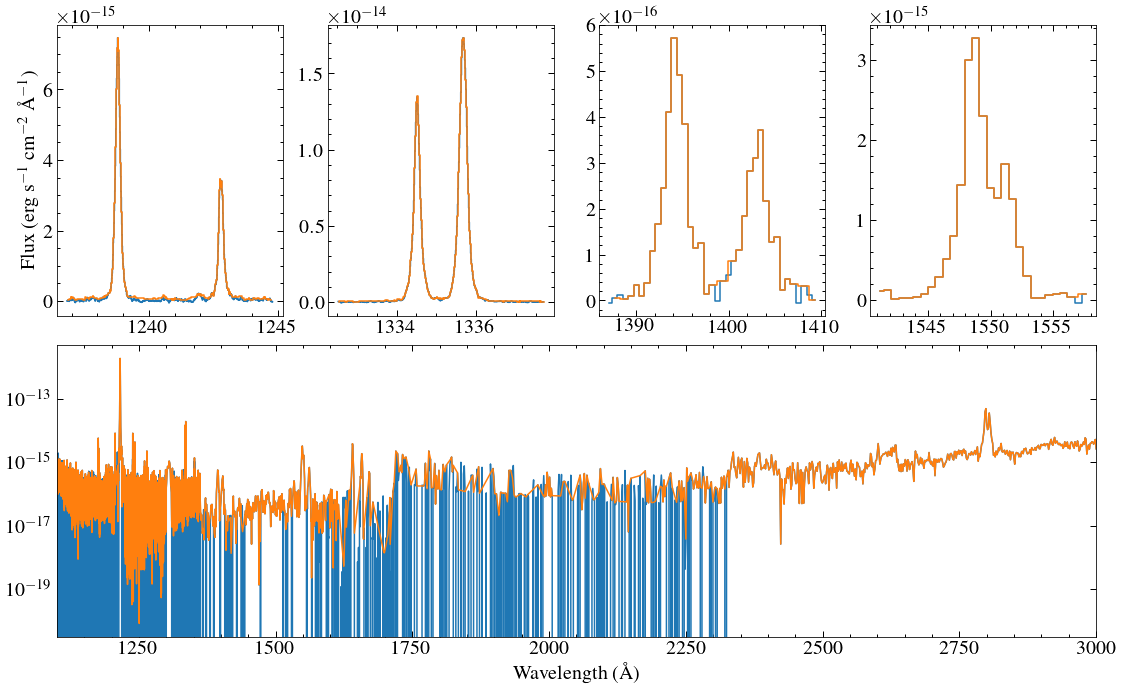

GJ1132


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


1214700
n ones 897
int og 1.358098370891653e-12
int nw 1.5380808987373213e-12
ratio 0.8829824048959818


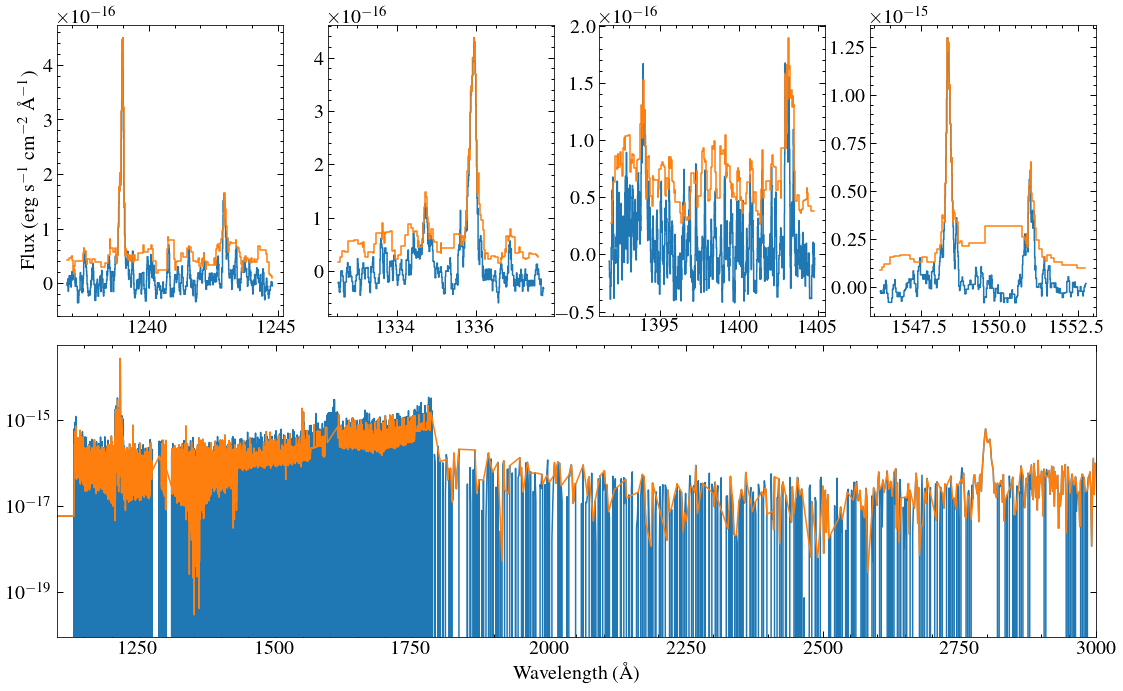

GJ15A


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


1173337
n ones 1549
int og 1.578601895405122e-10
int nw 1.735239844907818e-10
ratio 0.9097312397693259


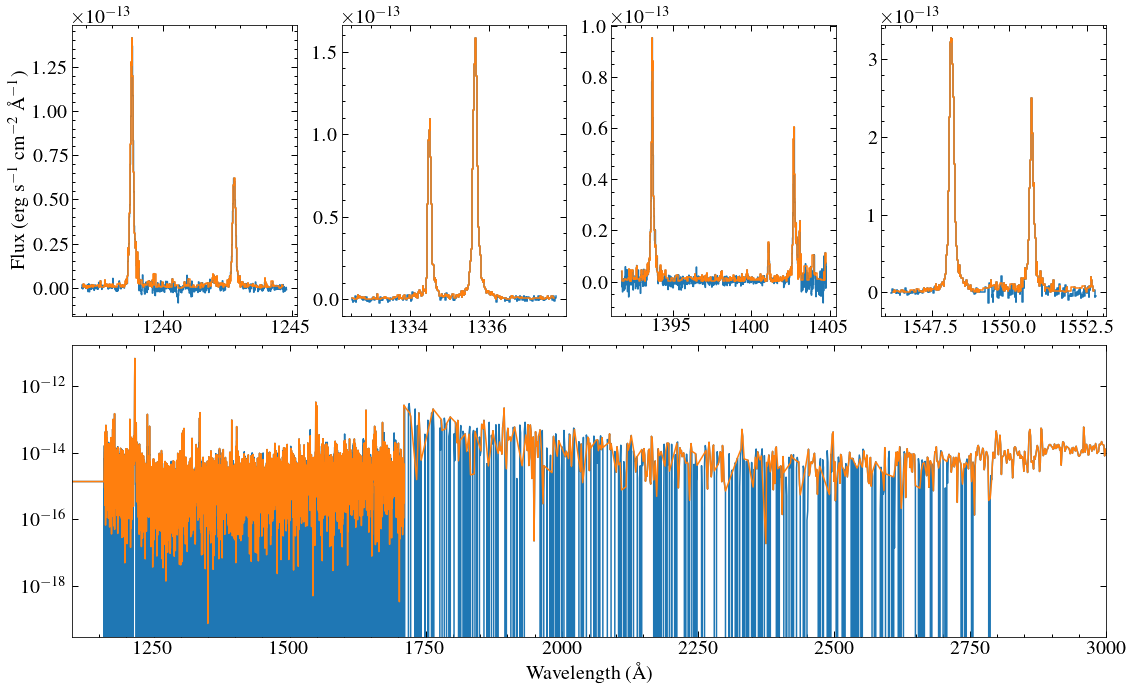

GJ163


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


1171124
n ones 1505
int og 6.849077272558882e-12
int nw 6.9761416653047505e-12
ratio 0.9817858640431842


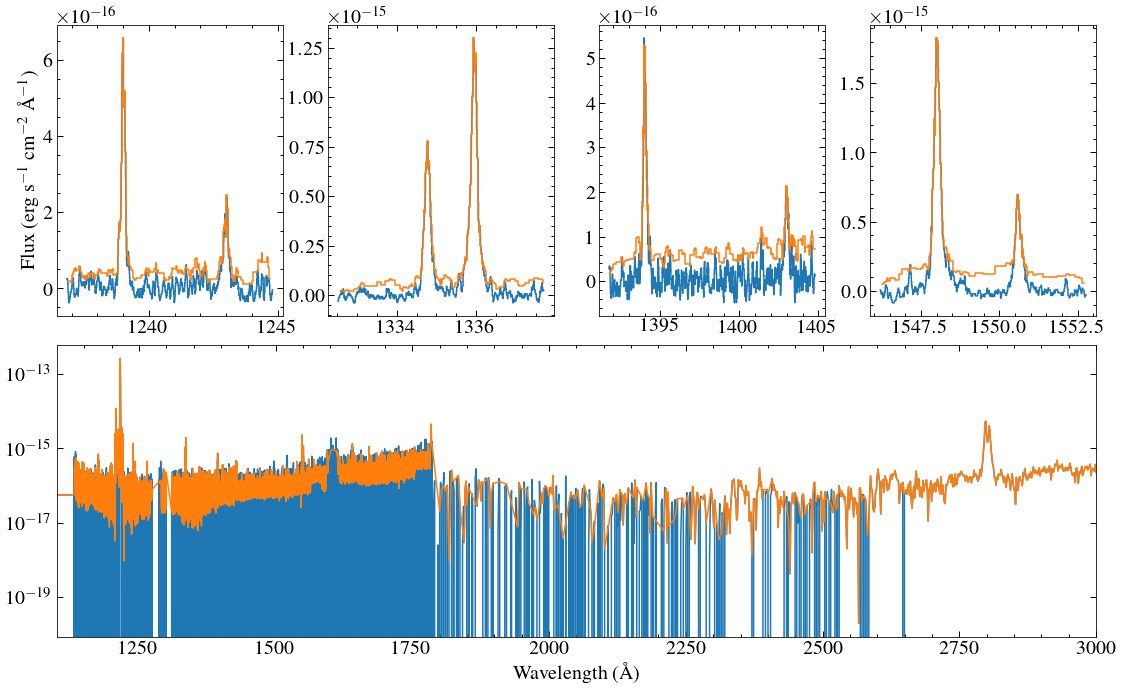

GJ674


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


1183841
n ones 1639
int og 5.260802836018257e-11
int nw 5.287141226450724e-11
ratio 0.9950184061093922


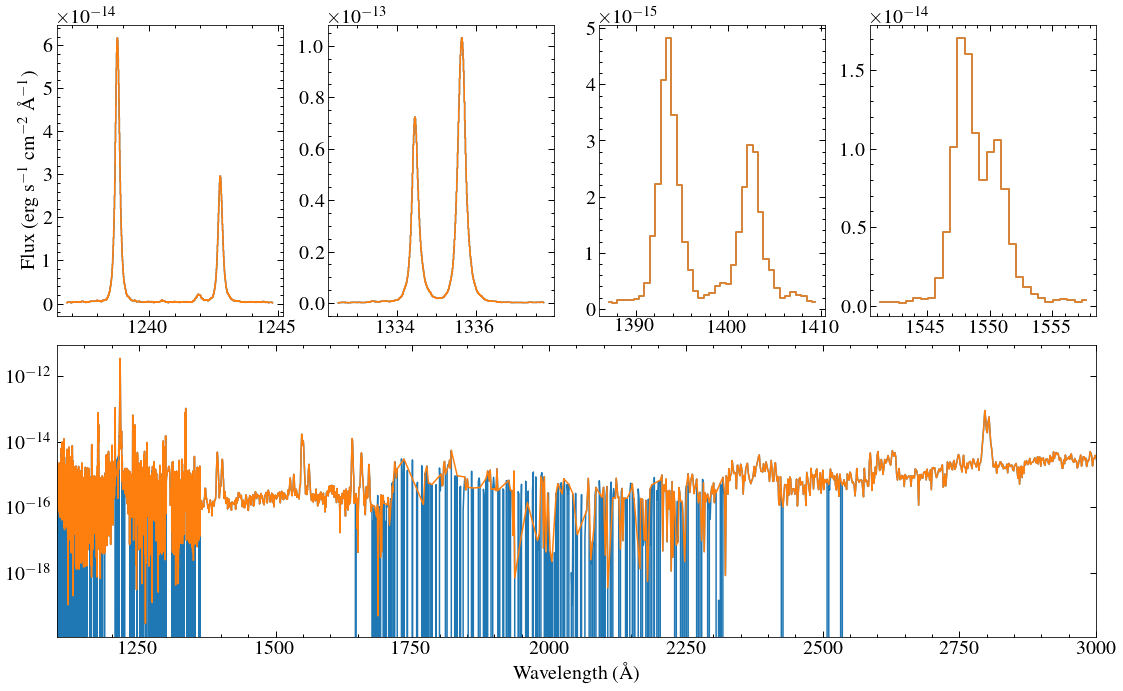

GJ676A


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


1121083
n ones 1834
int og 4.4384305855120664e-11
int nw 4.450445953293794e-11
ratio 0.9973001879119923


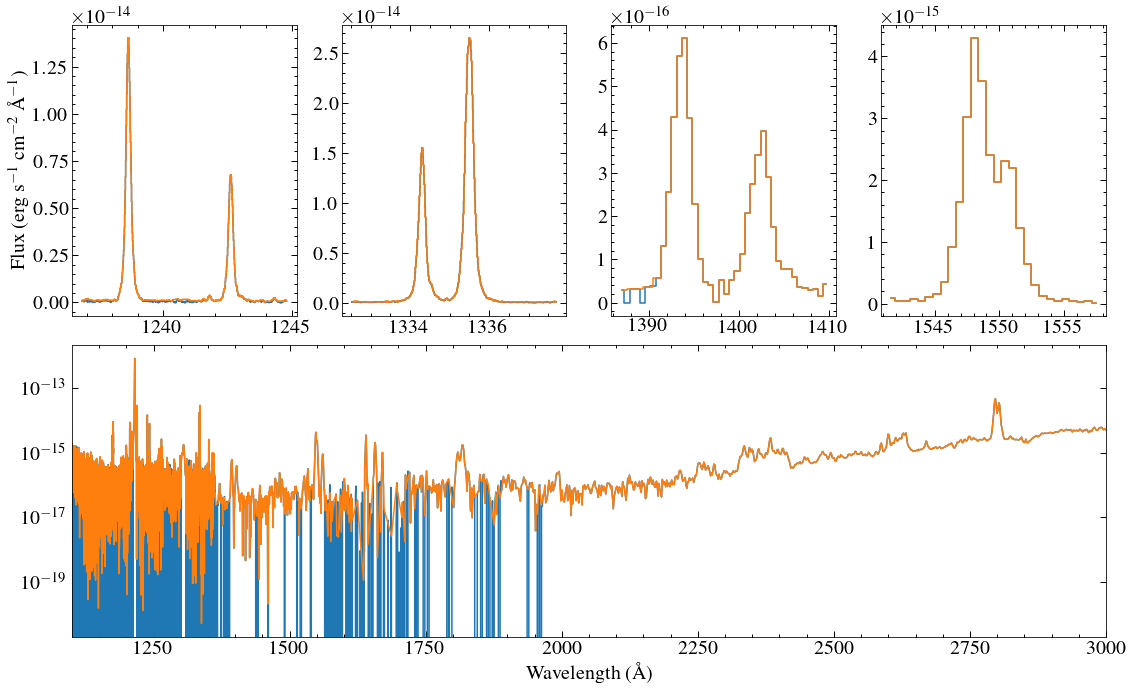

GJ699


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


1178253
n ones 1542
int og 3.522128435190675e-11
int nw 3.5469223886353474e-11
ratio 0.993009727665845


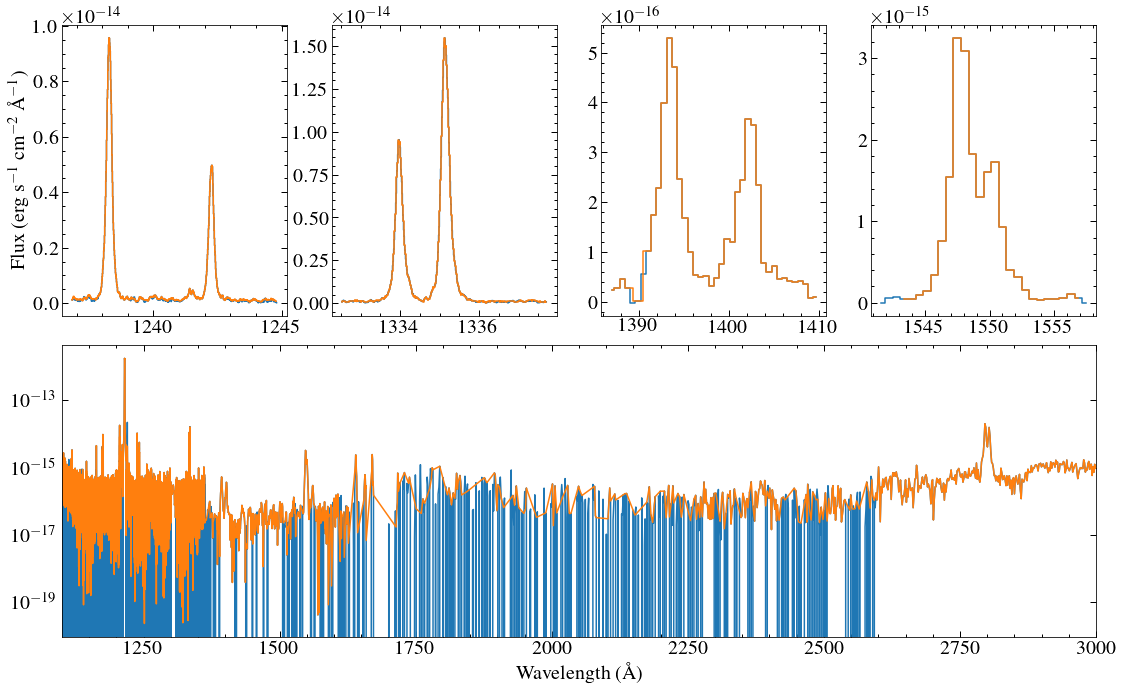

GJ729


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


1170011
n ones 1389
int og 3.5870725589843935e-11
int nw 5.0205872839906304e-11
ratio 0.7144727013157706


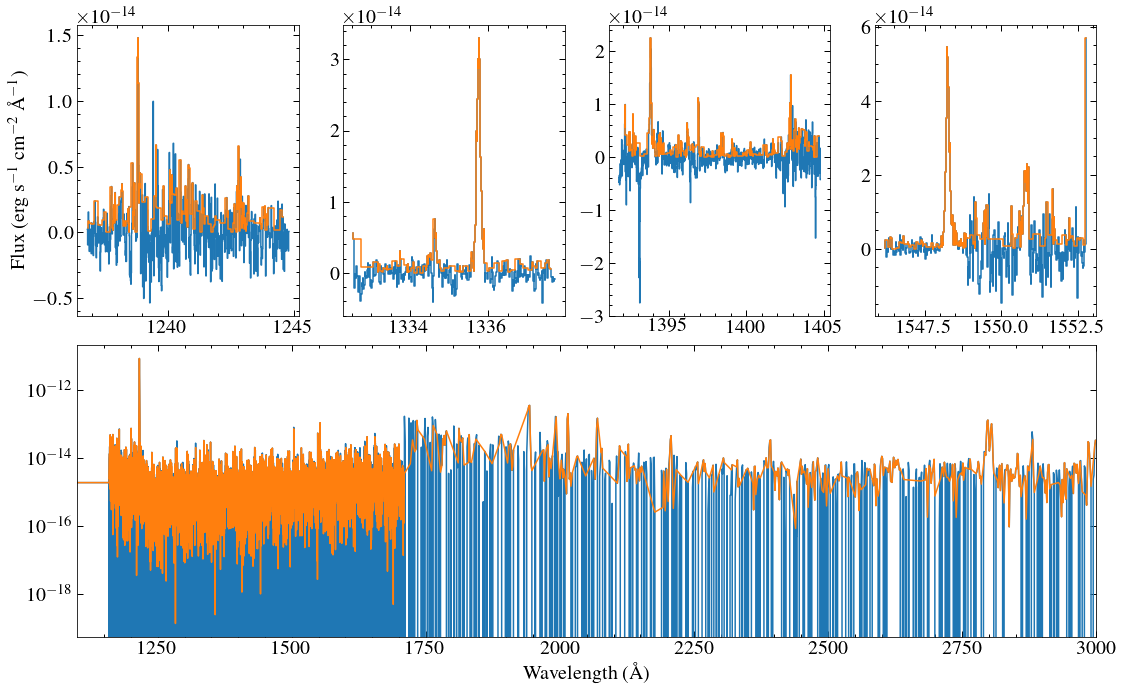

GJ849


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


1176123
n ones 1532
int og 2.47115823618757e-11
int nw 2.4930607126194787e-11
ratio 0.9912146237269547


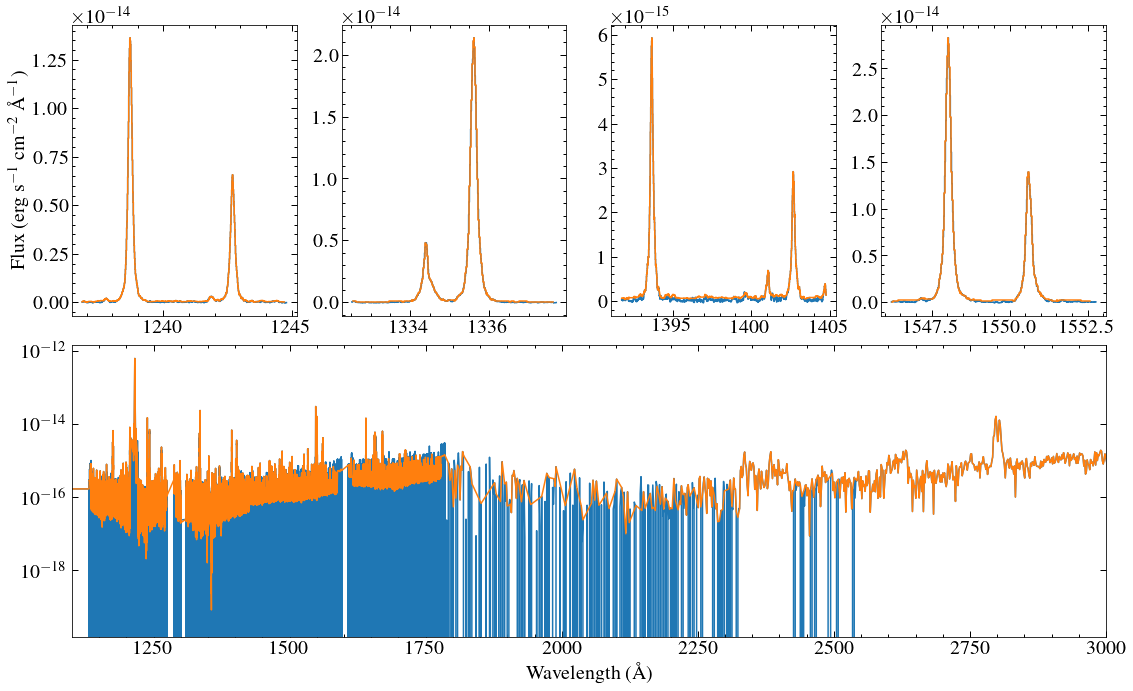

L-980-5


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


1181533
n ones 1253
int og 1.8130263052591454e-12
int nw 1.912104377716743e-12
ratio 0.9481837531401358


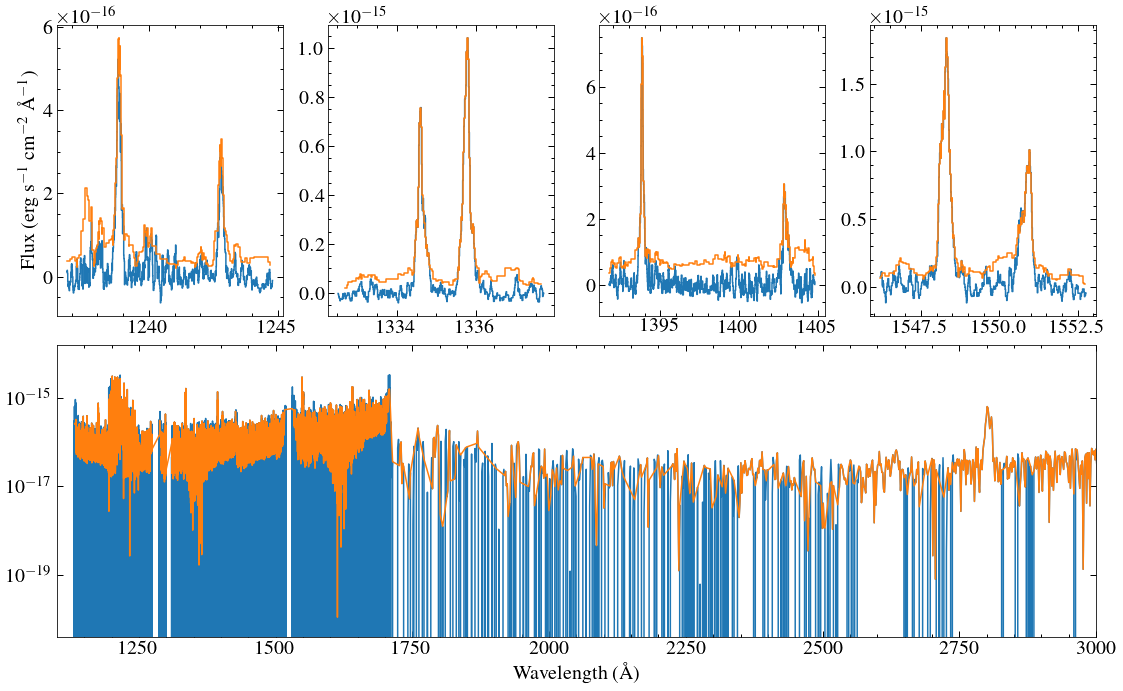

LHS-2686


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


1171757
n ones 1823
int og 8.786598112795096e-13
int nw 9.970365047752906e-13
ratio 0.8812714550281582


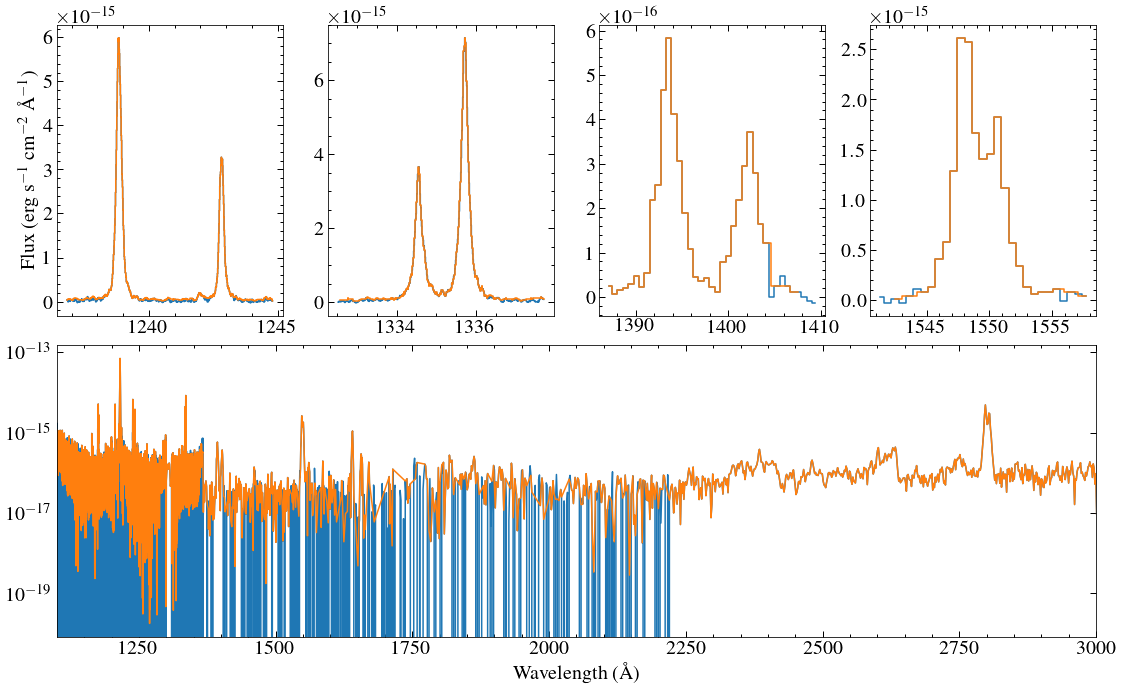

2MASS-J23062928-0502285


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


1128762
n ones 1076
int og 2.832275254165363e-13
int nw 5.889066028883346e-13
ratio 0.48093793485660824


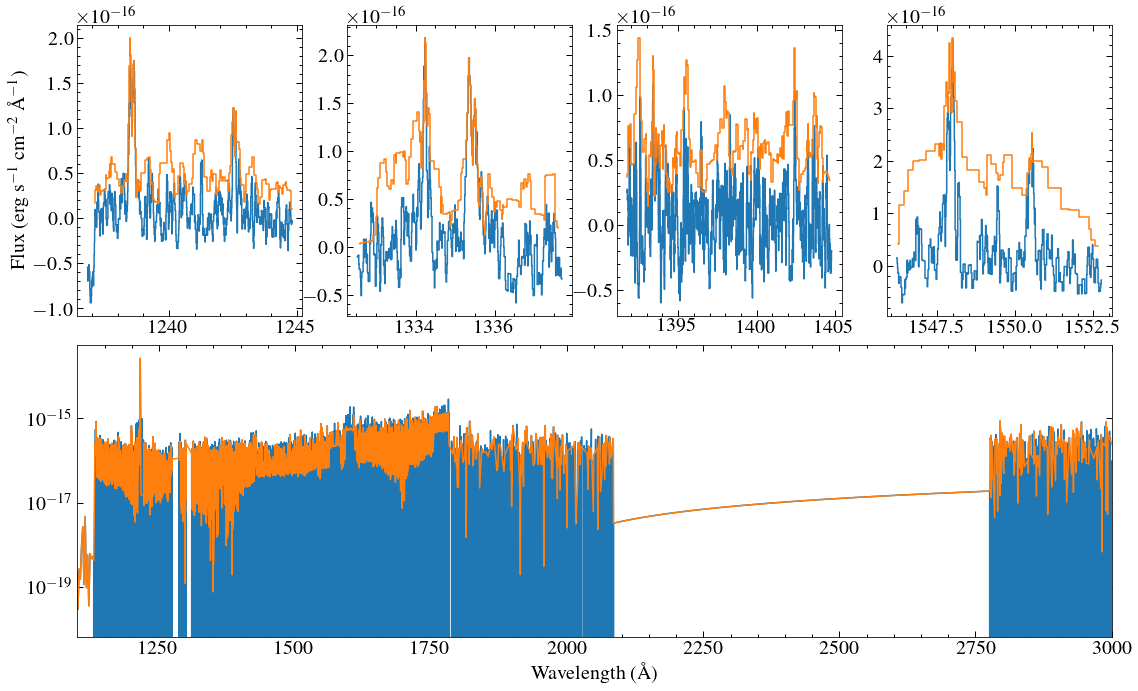

In [50]:
stars = []

dvs = np.array([-3.2179626137386097,  40.08741304111106, -8.29172387532275, 36.44496578836573, 
       -8.496187662426907, -44.461822449302915, -124.3703158406861,12.180515773744279,
      -22.9621644919636, 16.10168084165221, 5.910544014529296,-62.558323075720324])*u.km/u.s


doublets = np.array([[1238.821, 1242.804],[1334.524,1335.709],[1393.755,1402.77],[1548.201,1550.772]])
all_lines = doublets.flatten()
names = ['N\,v', 'C\,II', 'Si\,IV', 'C\,IV']
# dv_guess = np.array(ref_dvs)*u.km/u.s

for j, spec in enumerate(specs):
#     print(spec)
    plt.figure(figsize = (4*len(doublets), 10))
    gs = GridSpec(2, 4)
    data = fits.getdata(spec, 1)
    star = fits.getheader(spec)['TARGNAME']
    print(star)
    stars.append(star)
    w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
    wn, fn, en = remove_negatives(w, f, e, line_groups, dv=dvs[j])
    diffs = np.diff(wn[wn < 5700])
    print('n ones', len(diffs[diffs >1]))
    print('int og', np.trapz(f[w < 4000], w[w < 4000]))
    print('int nw', np.trapz(fn[wn < 4000], wn[wn < 4000]))
    print('ratio', np.trapz(f[w < 4000], w[w < 4000])/np.trapz(fn[wn < 4000], wn[wn < 4000]))
    
    # lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']

    smooth =7 


    for i, lines in enumerate(doublets):
#         plt.subplot(1, len(doublets) , i+1)
        plt.subplot(gs[0, i])
        if i == 0:
            plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
#         start, end = lines[0]-5, lines[1]+5
        mask = (w >= lines[0]-7) & (w <= lines[1]+7)
        maskn = (wn >= lines[0]-7) & (wn <= lines[1]+7)
        if np.median(inst[mask]) in [1, 2, 16]:
            mask = (w >= lines[0]-2) & (w <= lines[1]+2)
            maskn = (wn >= lines[0]-2) & (wn <= lines[1]+2)
        wi, fi, ei = w[mask], f[mask], e[mask]
        wj, fj, ej = wn[maskn], fn[maskn], en[maskn]
        if np.median(inst[mask]) in [1, 2]:
            fi = convolve(fi,Box1DKernel(smooth))
            ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
            fj = convolve(fj,Box1DKernel(smooth))
            ej = convolve(ej,Box1DKernel(smooth))/smooth**0.5
#         plt.errorbar(wi, fi, yerr =ei, errorevery=5)
#         plt.errorbar(wj, fj, yerr =ej, errorevery=5)
        plt.step(wi, fi, where='mid')
        plt.step(wj, fj, where='mid')
        
    #         print(std_guess)
    
    plt.subplot(gs[1, :])
    plt.plot(w[w< 4000], f[w< 4000])    
    plt.plot(wn[wn< 4000], fn[wn< 4000])
    plt.yscale('log')
    plt.xlabel('Wavelength (\AA)')
    
    plt.xlim(1100, 3000)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.1)
#     plt.savefig('rv_plots/{}_rv.png'.format(star), dpi=150)
#     plt.savefig('rv_plots/{}_rv.pdf'.format(star), dpi=150)
    plt.show()
    
    #     start += step


Let's make a fake spectrum and test it.

200
0
0.42262148445377695
51
1.8189011745916552
51
1.8189011745916552


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


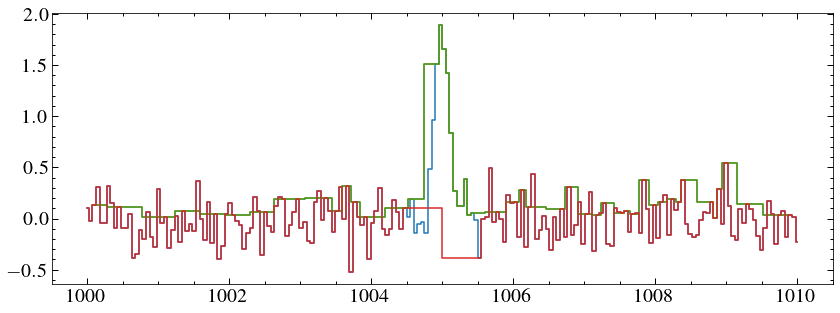

In [88]:

# Generate fake data
np.random.seed(42)
g1 = models.Gaussian1D(2, 1005, 0.1)
# g2 = models.Gaussian1D(2.5, 0.5, 0.1)
x = np.linspace(1000, 1010, 200)
y = g1(x) + np.random.normal(0., 0.2, x.shape)
z = np.random.normal(0., 0.2, x.shape)

plt.step(x, y, where='mid')
print(len(x))
print(len(x[x<0]))
print(np.trapz(y,x))
xn, yn, zn = remove_negatives(x, y, z,[[20]], dv=0*u.km/u.s)

plt.step(xn, yn, where='mid')
print(len(xn))
print(np.trapz(yn,xn))



xn, yn, zn = remove_negatives(x, y, z,[[1005]], dv=0*u.km/u.s)

plt.step(xn, yn, where='mid')
print(len(xn))
print(np.trapz(yn,xn))


mask = make_line_mask(x, [[1005]], dv=0*u.km/u.s)
xl, yl, zl = x[mask], y[mask], z[mask]
plt.step(xl, yl, where='mid')